---
title: "The importantance of propper initializtaion"
author: "Alex Kelly"
format:
  html:
    code-fold: true
    toc : true
    numbered-sections : true
jupyter: python3
draft : True
---

# Why am I writing about LSUV?

I'm watching online videos series by Fast.ai where we are looking at re-creating neural networks from scratch using Python
ensuring we fully understand innerworkings of each aspect of a nerual network. This will enable me to create new techniques
and improve existing techniques and enable me to piece together the right neural network for the right task.   

On top of that we meet up online for a study group and share/discuss what we have been studying.  This blog post is why we need
a better way to initialize weights than just choosing random values.

# Why initialization model weights before starting the optimization  

![](weight_initialization.png)


Proper initialization can affect how quickly the model converges to a minimum loss, or even whether it converges at all.  Its not just about the initialization of the 1st layer of weights, its about all the weights from layer 1 to the last to the outputs.  

Here are a few key points on weight initialations :

1. The hardware has floating point limitations that mean it processes limited number of bits and stores in a limited amount of memory.   If the weights are too high or too low then it ends up calculating the results with too high or too low to store into memory specified which are called exploding or vanishing neurons (i.e.. dead neurons) at anypoint level in the nereual network.  This results in information lost, which are called dead neurons or neurons that dont contribute to the end result in a optimal way.  
2.  The mean should be close to zero,  if the number is far away from zero, you will more likely end up with exploding or vanishing neurons (i.e.. dead neurons) that don't contribute to the end prediction or classification.  Enforcing a mean of zero is a way to optimize the weights so when calculated against the inputs they give a optimal result in the floating point range that the hardware can handle.
3. The standard deviation should be near 1 so that the values don't vary too far from the mean (i.e. 0 mentioned in point 2).  A standard deviation that's too high or too low could lead to weights that are too disparate or too similar, affecting the learning dynamics.

# LSUV vs other methods

Each model comes with its own issues and choosing the right initialization model is key to success.  Some initializations work better with large models, some with small and some depend on the activation functions, sometimes you have to experiment to see which ones work best.  Here are a few examples of initialization techniques :

- LSUV (Layer-Sequential Unit-Variance) Initialization
- Zero Initialization
- Random Initialization
- Xavier/Glorot Initialization
- He Initialization
- LeCun Initialization

LSUV is a valuable weight initialization technique, especially for deeper architectures where traditional techniques might not be as effective. However, the choice of weight initialization should be based on the network architecture, activation function, and specific challenges of the problem at hand.

# A walk through of the code and results

A walk through of the code and the results of the developing an LSUV callback into the FASTAI mini AI learner.  We will be covering :

- Setting up the enviroment, loading the data set and finding the learning rate.
- Running the learner without LSUV or any other initialization techniques and exploring the results.
- Weight initialization using kaimings method
- LSUV training method
- Conclusion of the results


# Setup enviroment, loading the dataset, transforming the data for training

This code sets up a pipeline to preprocess and load the Street View House Numbers (SVHN) dataset for machine learning with PyTorch. It installs required packages, imports libraries, configures settings, fetches the dataset, converts images to grayscale, applies data transformations, and creates data loaders for training.

In [ ]:
#| echo: False
#| output: False
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#| echo: False
#| output: False
import sys
sys.path.append('/content/drive/MyDrive/Learning/data_science/miniai/')

In [ ]:
#| echo: True
#| output: False
#| code-summary :  ....click to expand code


# install required libraries
!pip install datasets
!pip install torcheval

# Python Standard Library imports
import math
import logging
from collections.abc import Mapping
from operator import attrgetter
from functools import partial
from copy import copy
from contextlib import contextmanager
import random

# Third-party library imports
import torch
import matplotlib.pyplot as plt
import matplotlib as mpl
import torchvision.transforms.functional as TF
from datasets import load_dataset, load_dataset_builder
import fastcore.all as fc
from fastprogress import progress_bar, master_bar
from fastcore.test import test_close
from torch.nn import init
from torch import nn,tensor
from torch import optim
import torch.nn.functional as F
from torcheval.metrics import MulticlassAccuracy, Mean
import numpy as np

# Custom module imports
from conv import *
from miniai.datasets import *
from miniai.conv import *
from miniai.learner import *
from miniai.activations import *

# Configuration settings
torch.set_printoptions(precision=2, linewidth=140, sci_mode=False)
torch.manual_seed(1)
mpl.rcParams['image.cmap'] = 'viridis'
logging.disable(logging.WARNING)


# get labels
x,y = 'image','label'

#  Street View House Numbers dataset name
name = ('svhn')

# fetch dataset from hugging face
dsd = load_dataset(name, "cropped_digits",)

# remove extra (not required for initial run through)
dsd.pop("extra")

# convert images to greyscale
def convert_to_gray(batch):
    image = batch['image']
    if image.mode != 'L':  # Only convert if not already grayscale
        gray_image = image.convert('L')
        batch['image'] = gray_image
    return batch

# Apply to all datasets
for key in dsd.keys():
    dsd[key] = dsd[key].map(convert_to_gray, batched=False)

# transform data
@inplace
def transformi(b): b[x] = [torch.flatten(TF.to_tensor(o)) for o in b[x]]

# extract data set
bs = 1024
tds = dsd.with_transform(transformi)
dls = DataLoaders.from_dd(dd=tds, batch_size=bs, num_workers=1)


dt = dls.train
xb,yb = next(iter(dt))
xb.shape,yb[:10]



(torch.Size([1024, 1024]), tensor([2, 6, 2, 2, 5, 2, 2, 1, 7, 2]))

In [ ]:
#| echo: False
#| output: False

tds["train"]["image"][55]



tensor([0.76, 0.76, 0.76,  ..., 0.65, 0.68, 0.66])

In [ ]:
#| echo: False
#| output: False

tds["train"]["image"][55].shape


torch.Size([1024])

#| echo: True
#| output: True

# Find the optimal learning rate

The Learning Rate Finder is a tool designed to help find a good learning rate for training deep learning models. It increases the learning rate after each mini-batch and records the loss. As the learning rate increases, initially, the loss will decrease (as the model learns). But after a certain point, the learning rate might be too high causing the loss to increase due to overshooting the optimal weights.  The usual method is to choose the best learning rate is to choose a figure just before the steep fall.

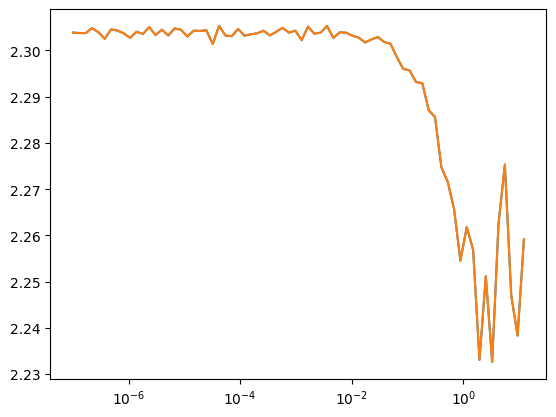

In [ ]:
#| echo: True
#| output: True
#| fig-cap : "Learning rate finder graph, the graph shows the relationship between learning rate (x-axis) and loss (y-axis)."
#| code-summary :  From looking at the chart, it looks like the best learning rate is going to be between 10^-2 and 10^-1.... click to expand code

# transform dataset and loader
@inplace
def transformi(b): b[x] = [TF.to_tensor(o) for o in b[x]]

tds = dsd.with_transform(transformi)
dls = DataLoaders.from_dd(tds, bs, num_workers=2)
dt = dls.train

lrfind = LRFinderCB()
cbs = [TrainCB(), DeviceCB(), lrfind]

# fits data
def fit(model, epochs=1, xtra_cbs=None):
    learn = Learner(model, dls, loss_func=F.cross_entropy, lr=0.0000001, cbs=cbs+fc.L(xtra_cbs))
    learn.fit(epochs)
    return learn

# conv function takes in kernal size, stride (how many elements are skipped) and padding (number of zeros added to the edge of the input data)
# along with ni (features) input channels and output channels (feature maps)

def conv(ni, nf, ks=3, act=True):
    res = nn.Conv2d(ni, nf, stride=2, kernel_size=ks, padding=ks//2)
    if act: res = nn.Sequential(res, nn.ReLU())
    return res

#

def cnn_layers():
    return [
        conv(1 ,8, ks=5),        #14x14
        conv(8 ,16),             #7x7
        conv(16,32),             #4x4
        conv(32,64),             #2x2
        conv(64,10, act=False),  #1x1
        nn.Flatten()]

model = nn.Sequential(*cnn_layers())

fit(model);

plt.plot(lrfind.lrs, lrfind.losses)
plt.xscale('log')



# Example of poorly initialized (No input or weight initialization)

This section will show training pipeline and charts that show key metrics of the training with annotations of how it faired.
<br>

Key technnical information for this section :
<br>

**Conv 1,8,16,32,64 -> 10 :** A Convultion neural network showing the number of filters in each layer and ending with 10 output units.
<br> **Activation is nn.ReLU :** ReLU function introduces non-linearity to the model.
<br> **Color_dim :** Shows a small band of yellow at the bottom of the chart from batch 1 until the end representing a lot of dead neurons all the way.
<br> **Dead_chart :** More proof neurons are dead at the start and not contributing to the end result.
<br> **Plot_stats :** Means close to zero but standard deviations far off expected goal of 1, to far from 1 to train optimally.

accuracy,loss,epoch,train
0.186,2.248,0,train
0.196,2.225,0,eval


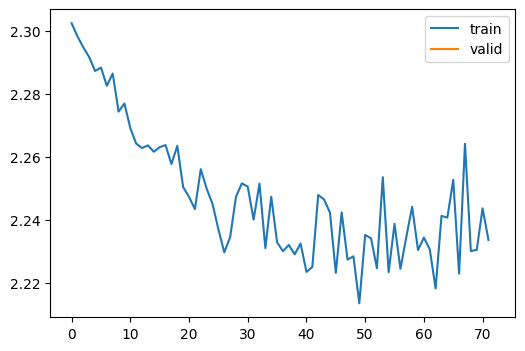

In [ ]:
#| echo: True
#| output: True
#| fig-cap : "Learning rate finder graph, the graph shows the relationship between learning rate (x-axis) and loss (y-axis)."
#| code-summary : fill in what teh chart shows .... click to expand code

# improved function to include labelling
class ActivationStats(HooksCallback):
    def __init__(self, mod_filter=fc.noop):
        super().__init__(append_stats, mod_filter)

    def color_dim(self, figsize=(11,5)):
      fig, axes = get_grid(len(self), figsize=figsize)
      for ax, h in zip(axes.flat, self):
          im = ax.imshow(get_hist(h), origin='lower')  # Using imshow directly

          # Add labels, title, and colorbar for clarity
          ax.set_xlabel("Batch Number")
          ax.set_ylabel("Activation Value")
          ax.set_title("Layer " + "str(self.index(h))" + " Activations")
          cbar = plt.colorbar(im, ax=ax)
          cbar.set_label("Frequency")
      plt.tight_layout()  # Prevent overlap


    def dead_chart(self, figsize=(11,5)):
        fig, axes = get_grid(len(self), figsize=figsize)
        for ax, h in zip(axes.flatten(), self):
            ax.plot(get_min(h), linewidth=3)
            ax.set_ylim(0,1)
            ax.set_xlabel("Batch Number")
            ax.set_ylabel("Activation Value")
            ax.set_title("Layer " + "str(self.index(h))" + " Dead Activations")
        plt.tight_layout()  # Prevent overlap

    def plot_stats(self, figsize=(10,4)):
        fig, axs = plt.subplots(1,2, figsize=figsize)
        for h in self:
            for i in 0,1:
                axs[i].plot(h.stats[i])
        axs[0].set_title('Means')
        axs[1].set_title('Stdevs')
        axs[0].set_xlabel("Batch Number")
        axs[1].set_xlabel("Batch Number")
        axs[0].set_ylabel("Mean Activation Value")
        axs[1].set_ylabel("Standard Deviation of Activation Value")
        plt.legend(fc.L.range(self))
        #plt.tight_layout()  # Prevent overlap

# transform dataset and loader
@inplace
def transformi(b): b[x] = [TF.to_tensor(o) for o in b[x]]

tds = dsd.with_transform(transformi)
dls = DataLoaders.from_dd(tds, bs, num_workers=2)
dt = dls.train

# setup model for learning
metrics = MetricsCB(accuracy=MulticlassAccuracy())
cbs = [TrainCB(), DeviceCB(), metrics, ProgressCB(plot=True)]

# fits dataset
def fit(model, epochs=1, xtra_cbs=None):
    learn = Learner(model, dls, loss_func=F.cross_entropy, lr=0.2, cbs=cbs+fc.L(xtra_cbs))
    learn.fit(epochs)
    return learn

# conv function takes in kernal size, stride (how many elements are skipped) and padding (number of zeros added to the edge of the input data)
# along with ni (features) input channels and output channels (feature maps)
def conv(ni, nf, ks=3, act=True):
    res = nn.Conv2d(ni, nf, stride=2, kernel_size=ks, padding=ks//2)
    if act: res = nn.Sequential(res, nn.ReLU())
    return res

#
def cnn_layers():
    return [
        conv(1 ,8, ks=5),        #14x14
        conv(8 ,16),             #7x7
        conv(16,32),             #4x4
        conv(32,64),             #2x2
        conv(64,10, act=False),  #1x1
        nn.Flatten()]
model = nn.Sequential(*cnn_layers())

#astats = ActivationStats(fc.risinstance(GeneralRelu))
astats = ActivationStats(fc.risinstance(nn.ReLU))

fit(model, xtra_cbs=[astats]);

In [1]:
#| echo: True
#| output: True
#| fig-cap : "Colour chart to show dead neurons"
#| code-summary : The color represents the frequency of activations in a specific range. Using the viridis colormap, yellow indicates higher frequencies (many activations in that range), and purple indicates lower frequencies.   So, areas with more intense yellow mean those activation values occur more frequently for that batch.

astats.color_dim()

NameError: ignored

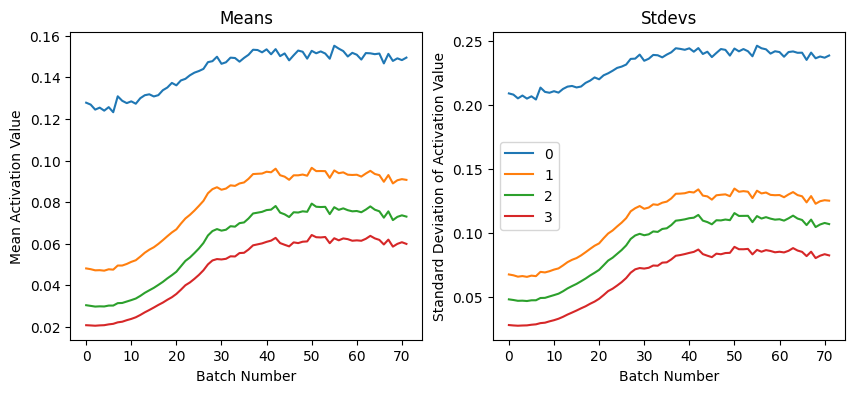

In [ ]:
#| echo: True
#| output: True
#| fig-cap : "Plots of means and standard deviations for each layer"
#| code-summary : Plots of means and standard deviations for each layer activations. Means should be close to zero and Stdevs should be close to 1 for optimal training


astats.plot_stats()

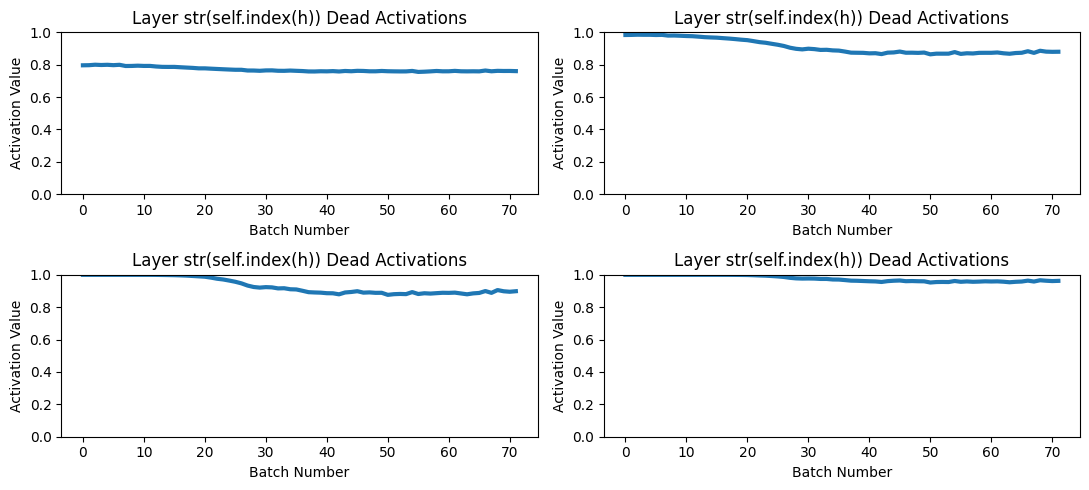

In [ ]:
#| echo: True
#| output: True
#| fig-cap : "plots of dead neurons (zero neurons) for each layer of the neural network, the lower the better so all neurons contribute to the result"
#| code-summary : plots of dead neurons (zero neurons) for each layer of the neural network, the lower the better so all neurons contribute to the result

astats.dead_chart()

# Initializing weights using kaimings method

This section presents the training pipeline and corresponding metrics visualized through various charts. Annotations provide insights into the model's performance during training.

By paying attention to these key metrics and visual cues, we can assess the shortcomings in the model's initialization and training regimen, specifically issues such as dead neurons and poorly tuned weight initializations. We can then compare them against previously un-initialized weights for any improvement.

<br>

Key Technical Information for This Section:

<br>
**Conv 1,8,16,32,64 -> 10 :** This denotes a Convolutional Neural Network with varying numbers of filters across different layers, culminating in 10 output units.
<br>
**Activation is nn.ReLU :** The model utilizes the ReLU (Rectified Linear Unit) activation function to introduce non-linearity, aiding in better approximations of complex functions.
<br>
**Color_dim :** In the chart, a yellow band stretching from the first batch until the end indicates a high incidence of 'dead' neurons, which are not contributing to the network's learning.
<br>
**Dead_chart :** This offers additional evidence that numerous neurons are inactive right from the start, leading to an inefficient learning process.
<br>
**Plot_stats :** The model's statistics reveal mean values that are close to zero, yet standard deviations that are significantly divergent from the ideal value of 1. This indicates that the model is not optimally configured for training.
<br>









In [2]:
#| echo: True
#| output: True
#| code-summary : Get the standard deviation and mean of the batch of data..... click to expand code


# get the mean and standard deviation.
# the mean should be close to 0
# the standard deviation wants to be close to 1
xmean,xstd = xb.mean(),xb.std()
xmean,xstd

NameError: ignored

Kaiming initialization sets the initial weights of each layer according to the following distribution:


$$
\text{weights} \sim \mathcal{N}\left(0, \sqrt{\frac{2}{\text{fan\_in}}}\right)
$$

weights are the weights of a particular layer<br>
fan_in is the number of input features to the layer (for CNNs, it's the number of input channels times the kernel height times the kernel width)<br>


In [ ]:
#| echo: True
#| output: True
#| code-summary : Apply Kaiming initialization to the data set..... click to expand code

xl,yl = 'image','label'
@inplace
def transformi(b): b[xl] = [(TF.to_tensor(o)-xmean)/xstd for o in b[xl]]
tds = dsd.with_transform(transformi)
dls = DataLoaders.from_dd(tds, bs, num_workers=2)
xb,yb = next(iter(dls.train))
# now the data is closer to where we want it.
xmean,xstd = xb.mean(),xb.std()
xmean,xstd

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


accuracy,loss,epoch,train
0.188,2.241,0,train
0.196,2.225,0,eval


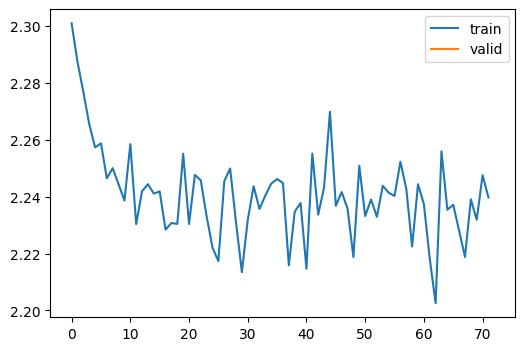

In [ ]:
#| echo: True
#| output: True
#| fig-cap : "Learning rate finder graph, the graph shows the relationship between learning rate (x-axis) and loss (y-axis)."
#| code-summary : The code sets up a deep learning pipeline for training a CNN model on a dataset. It defines transformations for the dataset, specifies data loaders, metrics, and callbacks, and then creates a CNN model with specific convolutional layers before fitting the model using a learner object with a reate of lr=0.2, and includes activation statistics..... click to expand code


# slightly better than last time but definatly not perfect>
model = nn.Sequential(*cnn_layers())
fit(model, xtra_cbs=[astats]);

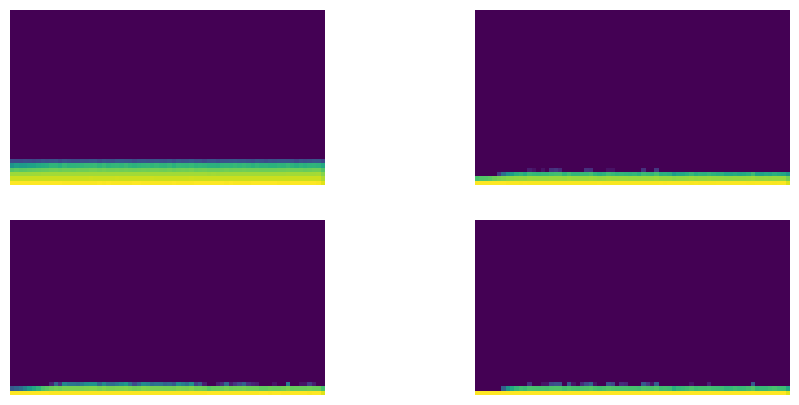

In [ ]:
#| echo: True
#| output: True
#| fig-cap : "Colour chart to show dead neurons"

astats.color_dim()

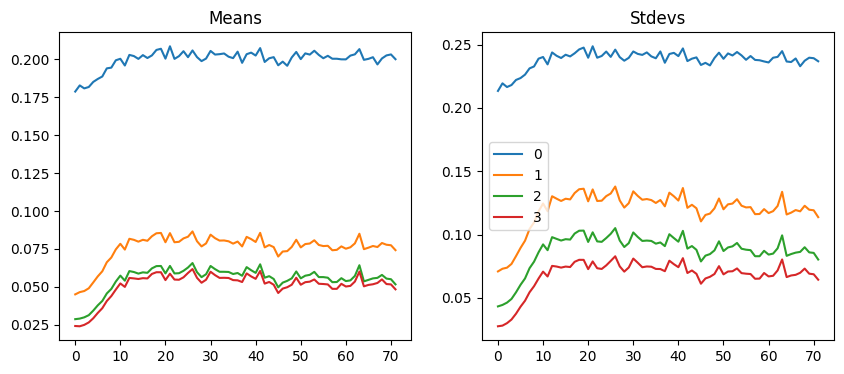

In [ ]:
#| echo: True
#| output: True
#| fig-cap : "Plots of means and standard deviations for each layer"


# stanard deviations still away from one but mean looks reasonable
astats.plot_stats()

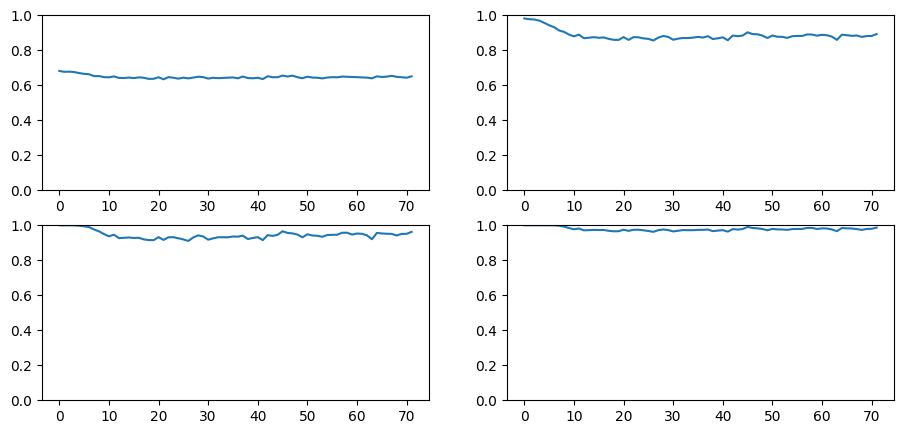

In [ ]:
#| echo: True
#| output: True
#| fig-cap : "plots of dead neurons (zero neurons) for each layer of the neural network, the lower the better so all neurons contribute to the result"
#| code-summary : plots of dead neurons (zero neurons) for each layer of the neural network, the lower the better so all neurons contribute to the result


# first layer quite bad and last layer is totally dead.
astats.dead_chart()

# Normalise batches using pytorch batchnorm2d    
<br>conv 1,8,16,32,64 -> 10
<br> leaky relu
<br> learning rate 0.2
<br> best training so far
<br> accuracy 0.830
<br> learning rate : 0.559
<br> also example of over training
<br> What to try next ????


In [ ]:
#| Avoiding Dead Neurons: Leaky ReLU helps to mitigate the problem of "dead neurons" that can occur with ReLU units,
# where neurons get stuck during training and always output a zero value. By allowing a small, non-zero output for negative inputs,
# Leaky ReLU ensures that gradients can still flow through the neuron, which can help to keep learning progressing.
class GeneralRelu(nn.Module):
    def __init__(self, leak=None, sub=None, maxv=None):
        super().__init__()
        self.leak,self.sub,self.maxv = leak,sub,maxv

    def forward(self, x):
        x = F.leaky_relu(x,self.leak) if self.leak is not None else F.relu(x)
        if self.sub is not None: x -= self.sub
        if self.maxv is not None: x.clamp_max_(self.maxv)
        return x

In [ ]:
#| export
def plot_func(f, start=-5., end=5., steps=100):
    x = torch.linspace(start, end, steps)
    plt.plot(x, f(x))
    plt.grid(True, which='both', ls='--')
    plt.axhline(y=0, color='k', linewidth=0.7)
    plt.axvline(x=0, color='k', linewidth=0.7)

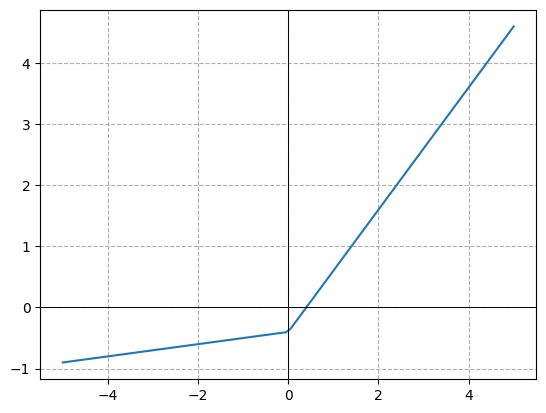

In [ ]:
# visual representation of the new relu, left values Jeremeys example
plot_func(GeneralRelu(leak=0.1, sub=0.4))

In [ ]:
#|export
def conv(ni, nf, ks=3, stride=2, act=nn.ReLU, norm=None, bias=None):
    if bias is None: bias = not isinstance(norm, (nn.BatchNorm1d,nn.BatchNorm2d,nn.BatchNorm3d))
    layers = [nn.Conv2d(ni, nf, stride=stride, kernel_size=ks, padding=ks//2, bias=bias)]
    if norm: layers.append(norm(nf))
    if act: layers.append(act())
    return nn.Sequential(*layers)

In [ ]:
#| initializes weights based on kaiming_normal_
def init_weights(m, leaky=0.):
    # checks for a instance of layer and module of the neural network
    # checks for a instance of 1d, 2d, 3d neural network
    #
    if isinstance(m, (nn.Conv1d,nn.Conv2d,nn.Conv3d)):
      # creates the initialization of the weights, for a, anything that is not zero, standard relu is assumed.
      init.kaiming_normal_(m.weight, a=leaky)

In [ ]:
# Creates a function based on relu with the parameters already applied
act_gr = partial(GeneralRelu, leak=0.1, sub=0.4)


In [ ]:
# Creates a function based on leaky being 0.1
iw = partial(init_weights, leaky=0.1)

In [ ]:
# Returns a instance of a model
#
def get_model(act=nn.ReLU, nfs=None, norm=None):
    # stores convolutions if not passed for later creation
    if nfs is None: nfs = [1,8,16,32,64]
    # Creates convolutions based on conv function for each of the layers in nfs
    layers = [conv(nfs[i], nfs[i+1], act=act, norm=norm) for i in range(len(nfs)-1)]
    return nn.Sequential(*layers, conv(nfs[-1],10, act=None, norm=False, bias=True),
                         nn.Flatten()).to(def_device)

In [ ]:
# collects mean and standard deviations of of each layer thats a ReLu
# astats = ActivationStats(fc.risinstance(nn.ReLU))
astats = ActivationStats(fc.risinstance(GeneralRelu))

In [ ]:
# addeds all call backs into a list for later use.
cbs = [DeviceCB(), metrics, ProgressCB(plot=True), astats]

In [ ]:
set_seed(42)
# Creates instance of the model and then applys kaiming_normal to the weights
model = get_model(act_gr, norm=nn.BatchNorm2d).apply(iw)
# Creates a instance of the learner function
learn = MomentumLearner(model, dls, F.cross_entropy, lr=0.2, cbs=cbs)
learn.fit(2)

RuntimeError: ignored

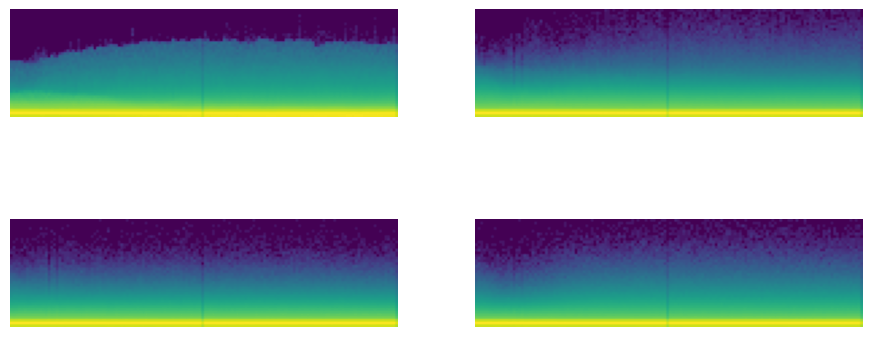

In [ ]:
astats.color_dim()

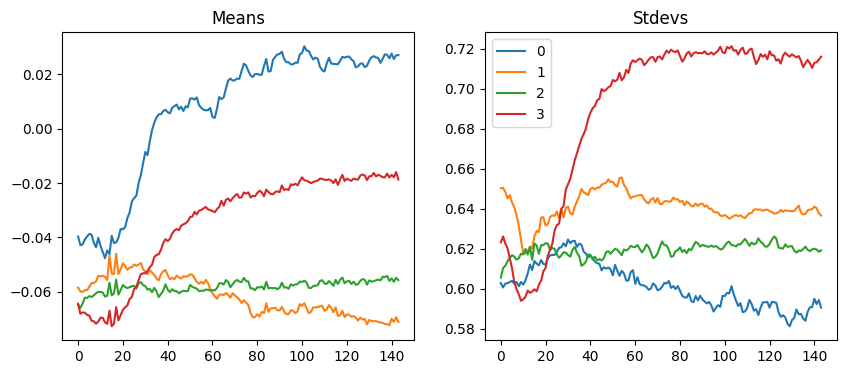

In [ ]:
astats.plot_stats()


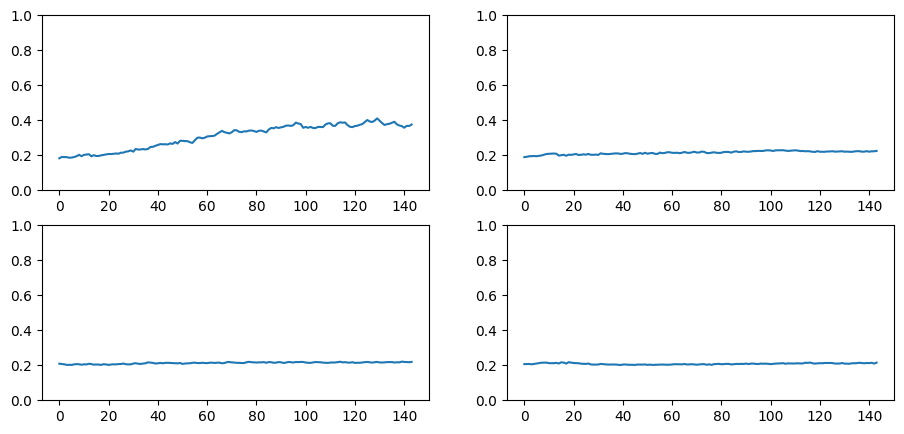

In [ ]:
astats.dead_chart()

# implement LSUV initialization as a class

In [ ]:
#| echo: True
#| output: True

from miniai.learner import *
from miniai.activations import *

In [ ]:
#| echo: True
#| output: True

bs = 1024

@inplace
def transformi(b): b[x] = [TF.to_tensor(o) for o in b[x]]

tds = dsd.with_transform(transformi)
dls = DataLoaders.from_dd(tds, bs, num_workers=1)
dt = dls.train
xb,yb = next(iter(dt))
xb.shape,yb[:10]

(torch.Size([1024, 1, 32, 32]), tensor([6, 1, 8, 2, 1, 1, 4, 1, 6, 5]))

In [ ]:
tds = dsd.with_transform(transformi)

In [ ]:
dls = DataLoaders.from_dd(dd=tds, batch_size=bs, num_workers=2)
dt = dls.train
xb,yb = next(iter(dt))
xb.shape,yb[:10]

(torch.Size([1024, 1, 32, 32]), tensor([3, 1, 6, 9, 3, 3, 7, 3, 3, 0]))

In [ ]:
# displays the tensor
tds["train"]["image"][55]

tensor([[[0.76, 0.76, 0.76,  ..., 0.65, 0.65, 0.61],
         [0.64, 0.64, 0.65,  ..., 0.68, 0.68, 0.62],
         [0.51, 0.51, 0.51,  ..., 0.71, 0.71, 0.63],
         ...,
         [0.67, 0.67, 0.67,  ..., 0.65, 0.69, 0.65],
         [0.73, 0.74, 0.75,  ..., 0.63, 0.67, 0.64],
         [0.76, 0.76, 0.77,  ..., 0.65, 0.68, 0.66]]])

In [ ]:
# shows the values 32 * 32 * 3 (RGB)
tds["train"]["image"][55].shape

torch.Size([1, 32, 32])

## rest of the code

In [ ]:
# This class implements Layer-Sequential Unit-Variance Initialization (LSUV), a technique used to
# initialize the weights and biases of neural networks. LSUV aims to set these parameters such that
# during the forward pass, the variance of the activations remains close to 1. This avoids issues
# commonly associated with poor initialization, such as vanishing or exploding gradients.
# To achieve this, the class modifies the initial weights and biases in the context of a sample of input
# data, targeting a specified range for hardware/software-specific floating-point representation. This approach
# minimizes the risk of exceeding the numerical range, which can lead to unstable training dynamics, or
# put anotherway reduces the number of neurons contributing (deactivate) and the weight into the final result.
# Key methods within this class handle the adjustment of weights and biases, based on the calculated
#  variances and means of the activations. This is typically invoked at the beginning of the training
# process, prior to the main training loop.

# Note: Initial tests have shown effective results, although chart visualizations may
# require further refinement.

class LSUVStatsHook(Callback):
  # initialize and store all relevent details to object
  def __init__(self, modules_for_hooks, modules_for_weights, verbose=False, debug=False):
    self.mean = None
    self.std = None
    self.log = fc.noop if not verbose else print
    self.debug = debug
    #fc.store_attr()
    if self.debug : import pdb; pdb.set_trace()
    self.modules_for_hooks = modules_for_hooks
    self.modules_for_weights = modules_for_weights

  # update hooks
  def hook(self, module, input, output):
    #import pdb;pdb.set_trace()
    acts = output.detach().cpu()
    self.mean = acts.mean()
    self.std = acts.std()

  # apply hooks to relus, update weights and bias to convs
  def calc_apply_LSUV_weights_bias(self, learn, batch_of_data):
    # Get all of the modules that will be used for calculating the  lsuv
    if self.debug : import pdb; pdb.set_trace()
    self.log("self.modules_for_hooks is type", self.modules_for_hooks)
    self.log("GeneralRelu is type " , GeneralRelu)
    modules_to_apply_hooks = [o for o in learn.model.modules() if isinstance(o, self.modules_for_hooks)]
    self.log("modules to apply hooks to: ", modules_to_apply_hooks)
    module_to_update_weights = [o for o in learn.model.modules() if isinstance(o, self.modules_for_weights)]

    # Update the weights and bias's util desired range is achieved
    if self.debug : import pdb; pdb.set_trace()
    no_of_layers = len(modules_to_apply_hooks)
    for item in range(no_of_layers):
      self.log("entering layer : ", item)
      handle = modules_to_apply_hooks[item].register_forward_hook(hook_LUSV.hook)
      with torch.no_grad():
        while learn.model(batch_of_data) is not None and (abs(hook_LUSV.std-1)>1e-3 or abs(hook_LUSV.mean)>1e-3):
          self.log("update weights to modules: ",  module_to_update_weights[item])
          module_to_update_weights[item].bias -= hook_LUSV.mean
          module_to_update_weights[item].weight.data /= hook_LUSV.std
          self.log("standard deviation is :", hook_LUSV.std)
          self.log("mean is :              ", hook_LUSV.mean)
    # deregister the hook
    handle.remove()

  # calls calc_apply_LSUV_weights_bias to update weights and bias's
  def before_fit(self, learn):
    if self.debug : import pdb; pdb.set_trace()
    LSUVStatsHook.calc_apply_LSUV_weights_bias(self, learn, batch_of_data=xb)




In [ ]:
class MetricsCB(Callback):
    def __init__(self, *ms, **metrics):
        import pdb; pdb.set_trace()
        for o in ms: metrics[type(o).__name__] = o
        self.metrics = metrics
        self.all_metrics = copy(metrics)
        self.all_metrics['loss'] = self.loss = Mean()

    def _log(self, d): print(d)
    def before_fit(self, learn): learn.metrics = self
    def before_epoch(self, learn): [o.reset() for o in self.all_metrics.values()]

    def after_epoch(self, learn):
        import pdb; pdb.set_trace()
        log = {k:f'{v.compute():.3f}' for k,v in self.all_metrics.items()}
        log['epoch'] = learn.epoch
        log['train'] = 'train' if learn.model.training else 'eval'
        self._log(log)

    def after_batch(self, learn):
        #import pdb; pdb.set_trace()
        x,y,*_ = to_cpu(learn.batch)
        for m in self.metrics.values(): m.update(to_cpu(learn.preds), y)
        self.loss.update(to_cpu(learn.loss), weight=len(x))
        print(f"loss : {learn.loss}, weight : {len(x)}")

In [ ]:
metrics = MetricsCB(accuracy=MulticlassAccuracy())



PYDEV DEBUGGER WARNING:
sys.settrace() should not be used when the debugger is being used.
This may cause the debugger to stop working correctly.
If this is needed, please check: 
http://pydev.blogspot.com/2007/06/why-cant-pydev-debugger-work-with.html
to see how to restore the debug tracing back correctly.
Call Location:
  File "/usr/lib/python3.10/bdb.py", line 336, in set_trace
    sys.settrace(self.trace_dispatch)



> <ipython-input-44-35d4a9117c1f>(4)__init__()
      2     def __init__(self, *ms, **metrics):
      3         import pdb; pdb.set_trace()
----> 4         for o in ms: metrics[type(o).__name__] = o
      5         self.metrics = metrics
      6         self.all_metrics = copy(metrics)

ipdb> 
ipdb> n
> <ipython-input-44-35d4a9117c1f>(5)__init__()
      3         import pdb; pdb.set_trace()
      4         for o in ms: metrics[type(o).__name__] = o
----> 5         self.metrics = metrics
      6         self.all_metrics = copy(metrics)
      7         self.all_metrics['loss'] = self.loss = Mean()

ipdb> c



PYDEV DEBUGGER WARNING:
sys.settrace() should not be used when the debugger is being used.
This may cause the debugger to stop working correctly.
If this is needed, please check: 
http://pydev.blogspot.com/2007/06/why-cant-pydev-debugger-work-with.html
to see how to restore the debug tracing back correctly.
Call Location:
  File "/usr/lib/python3.10/bdb.py", line 347, in set_continue
    sys.settrace(None)



In [ ]:
#| export
class GeneralRelu(nn.Module):
    def __init__(self, leak=None, sub=None, maxv=None):
        super().__init__()
        self.leak,self.sub,self.maxv = leak,sub,maxv

    def forward(self, x):
        x = F.leaky_relu(x,self.leak) if self.leak is not None else F.relu(x)
        if self.sub is not None: x -= self.sub
        if self.maxv is not None: x.clamp_max_(self.maxv)
        return x

In [ ]:
hook_LUSV = LSUVStatsHook(modules_for_hooks = GeneralRelu, modules_for_weights = nn.Conv2d,verbose=True,debug=False)

In [ ]:
def conv(ni, nf, ks=3, stride=2, act=nn.ReLU):
    res = nn.Conv2d(ni, nf, stride=stride, kernel_size=ks, padding=ks//2)
    if act: res = nn.Sequential(res, act())
    return res

In [ ]:
def get_model(act=nn.ReLU, nfs=None):
    if nfs is None: nfs = [1,8,16,32,64]
    layers = [conv(nfs[i], nfs[i+1], act=act) for i in range(len(nfs)-1)]
    return nn.Sequential(*layers, conv(nfs[-1],10, act=None), nn.Flatten()).to(def_device)

In [ ]:
act_gr = partial(GeneralRelu, leak=0.1, sub=0.4)
astats = ActivationStats(fc.risinstance((GeneralRelu, nn.ReLU)))

In [ ]:
model = get_model(act_gr)

In [ ]:
model

Sequential(
  (0): Sequential(
    (0): Conv2d(1, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): GeneralRelu()
  )
  (1): Sequential(
    (0): Conv2d(8, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): GeneralRelu()
  )
  (2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): GeneralRelu()
  )
  (3): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): GeneralRelu()
  )
  (4): Conv2d(64, 10, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (5): Flatten(start_dim=1, end_dim=-1)
)

In [ ]:
model

Sequential(
  (0): Sequential(
    (0): Conv2d(1, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): GeneralRelu()
  )
  (1): Sequential(
    (0): Conv2d(8, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): GeneralRelu()
  )
  (2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): GeneralRelu()
  )
  (3): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): GeneralRelu()
  )
  (4): Conv2d(64, 10, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (5): Flatten(start_dim=1, end_dim=-1)
)

In [ ]:
cbs = [DeviceCB(), metrics, ProgressCB(plot=True), astats, hook_LUSV]
#cbs = [DeviceCB(), metrics, ProgressCB(plot=True), astats]

self.modules_for_hooks is type <class '__main__.GeneralRelu'>
GeneralRelu is type  <class '__main__.GeneralRelu'>
modules to apply hooks to:  [GeneralRelu(), GeneralRelu(), GeneralRelu(), GeneralRelu()]
entering layer :  0
update weights to modules:  Conv2d(1, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
standard deviation is : tensor(0.18)
mean is :               tensor(-0.18)
update weights to modules:  Conv2d(1, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
standard deviation is : tensor(0.73)
mean is :               tensor(0.34)
update weights to modules:  Conv2d(1, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
standard deviation is : tensor(0.92)
mean is :               tensor(0.25)
update weights to modules:  Conv2d(1, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
standard deviation is : tensor(0.94)
mean is :               tensor(0.14)
update weights to modules:  Conv2d(1, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
standard deviation i

accuracy,loss,epoch,train
0.502,1.477,0,train
0.717,0.927,0,eval
0.776,0.730,1,train
0.787,0.726,1,eval
0.823,0.586,2,train
0.805,0.661,2,eval


loss : 2.3288421630859375, weight : 1024
loss : 2.4144644737243652, weight : 1024
loss : 2.362283706665039, weight : 1024
loss : 2.2671492099761963, weight : 1024
loss : 2.2612507343292236, weight : 1024
loss : 2.2662289142608643, weight : 1024
loss : 2.231084108352661, weight : 1024
loss : 2.2852299213409424, weight : 1024
loss : 2.2667036056518555, weight : 1024
loss : 2.2048332691192627, weight : 1024
loss : 2.1808979511260986, weight : 1024
loss : 2.163529872894287, weight : 1024
loss : 2.1725950241088867, weight : 1024
loss : 2.1274478435516357, weight : 1024
loss : 2.0760231018066406, weight : 1024
loss : 2.056678295135498, weight : 1024
loss : 2.0095269680023193, weight : 1024
loss : 1.9694942235946655, weight : 1024
loss : 1.9365414381027222, weight : 1024
loss : 1.875935673713684, weight : 1024
loss : 1.8481940031051636, weight : 1024
loss : 1.7602665424346924, weight : 1024
loss : 1.7638370990753174, weight : 1024
loss : 1.7370072603225708, weight : 1024
loss : 1.637526869773

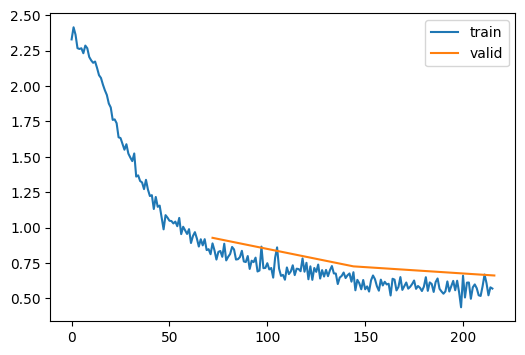

loss : 0.8880366086959839, weight : 1024
loss : 0.8387854695320129, weight : 1024
loss : 0.7737706899642944, weight : 1024
loss : 0.8279840350151062, weight : 1024
loss : 0.8342637419700623, weight : 1024
loss : 0.7931831479072571, weight : 1024
loss : 0.8856449127197266, weight : 1024
loss : 0.7678688168525696, weight : 1024
loss : 0.7933114767074585, weight : 1024
loss : 0.812987744808197, weight : 1024
loss : 0.8629277944564819, weight : 1024
loss : 0.8450809717178345, weight : 1024
loss : 0.7738507390022278, weight : 1024
loss : 0.7765510082244873, weight : 1024
loss : 0.7914267182350159, weight : 1024
loss : 0.8355770707130432, weight : 1024
loss : 0.7604403495788574, weight : 1024
loss : 0.7562274932861328, weight : 1024
loss : 0.7987656593322754, weight : 1024
loss : 0.7075282335281372, weight : 1024
loss : 0.7657550573348999, weight : 1024
loss : 0.7554774284362793, weight : 1024
loss : 0.7874916791915894, weight : 1024
loss : 0.6896514296531677, weight : 1024
loss : 0.69639390

In [ ]:
learn = MomentumLearner(model, dls, F.cross_entropy, lr=0.2, cbs=cbs)
learn.fit(3)

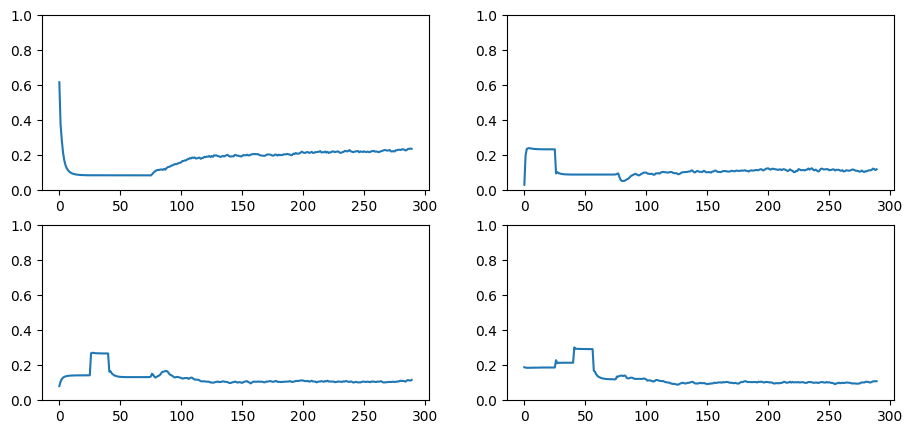

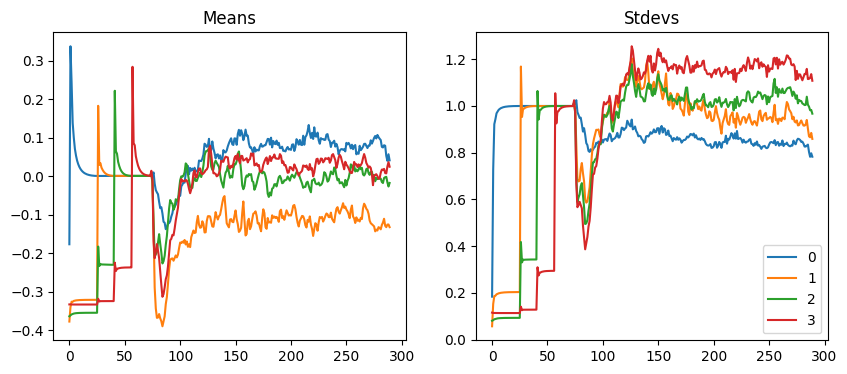

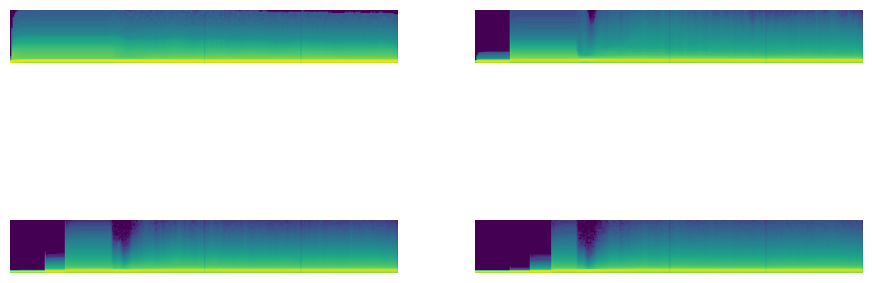

In [ ]:
astats.dead_chart();astats.plot_stats();astats.color_dim()